In [1]:
# Load Libraries 
import pandas as pd
import numpy as np
import time
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import scikitplot as skplt
from scipy.stats import uniform as sp_rand
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
import matplotlib.pyplot as plt
import matplotlib
import lime
import lime.lime_tabular
from tpot import TPOTClassifier
import joblib
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
domain_final = pd.read_csv('domain_final_features.csv')
target = domain_final['IsDGA']
feature_names = ['Length', 'Numbers', 'Entropy', 'first_digit_index', 'vowel_consonant_ratio']
feature_matrix = domain_final[feature_names]
#feature_matrix.shape
#target.head(5)
#target.value_counts()

In [4]:
# Splitting train and test data 75:25
feature_matrix_train, feature_matrix_test, target_train, target_test = train_test_split(feature_matrix, 
                                                                                        target, 
                                                                                        test_size=0.25)

In [5]:
feature_matrix_test.sample(5)

,Length,Numbers,Entropy,first_digit_index,vowel_consonant_ratio
259743,18,5,3.725481,8,0.300000
233601,18,3,3.836592,0,0.153846
45742,5,0,1.921928,-1,0.666667
189863,18,4,3.725481,7,0.400000
307945,18,5,4.058814,1,0.181818


In [6]:
decision_tree_clf = DecisionTreeClassifier()
decision_tree_clf.fit(feature_matrix_train, target_train)

DecisionTreeClassifier()

In [7]:
random_forest_clf = RandomForestClassifier(n_estimators=10, 
                                          max_depth=None,
                                          min_samples_split=2, 
                                          random_state=0)
random_forest_clf.fit(feature_matrix_train, target_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [8]:
svm_classifier = SVC ()
svm_classifier.fit(feature_matrix_train, target_train)

SVC()

In [9]:
def first_digit_index(x):
    n = re.search ("\d", x)
    if n:
        index = n.start()
        return index
    else:
        return -1

def vowel_consonant_ratio (x):
    x = x.lower()
    pattern_vowels = re.compile('([aeiou])')
    pattern_consonants = re.compile('[b-df-hj-np-tv-z]')
    vowels = re.findall(pattern_vowels, x)
    consonants = re.findall(pattern_consonants, x)
    try:
        ratio = len(vowels)/len(consonants)
    #exclue calculating 0 devision
    except: 
        ratio = 0
    return ratio

def calcEntropy(x):
    p, lens = Counter(x), np.float(len(x))
    return -sum(count/lens * np.log2(count/lens) for count in p.values())

    

In [10]:
def isDGA(domain, clf):
    df1 = pd.DataFrame ([[domain]], columns= ['domain'])
    df1['length'] = df1 ['domain'].str.len()
    df1['Numbers'] = df1['domain'].str.count('[0-9]')
    df1['Entropy'] = df1['Entropy'] = [calcEntropy(x) for x in df1['domain']]
    df1['first_digit_index'] = df1['domain'].apply(first_digit_index)
    df1['vowel_consonant_ratio'] = df1['domain'].apply (vowel_consonant_ratio)
    df1.drop ('domain', axis=1, inplace=True)
    #return df1
    return clf.predict(df1)[0]
    
isDGA('facebook', random_forest_clf)

0

In [11]:
#Feature importances
importances = random_forest_clf.feature_importances_
importances

array([0.32922305, 0.28231295, 0.37926053, 0.00548176, 0.00372171])

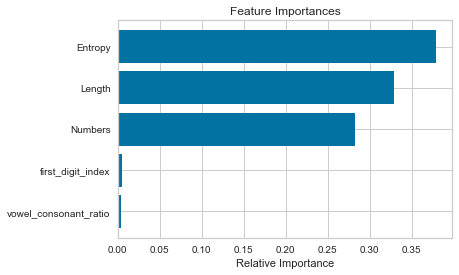

In [12]:
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [13]:
def plot_feature_importance(importance,names,model_type):
#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


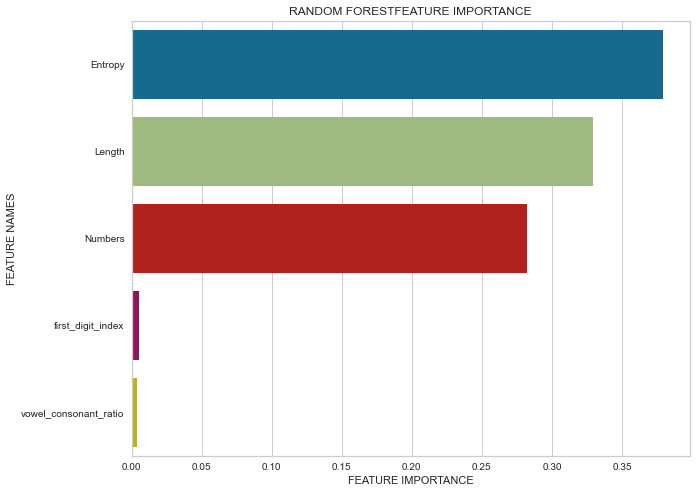

In [14]:
plot_feature_importance(random_forest_clf.feature_importances_, feature_names,'RANDOM FOREST')

In [15]:
#cross-validation score, rf
scores= cross_val_score (random_forest_clf, 
                        feature_matrix_train, 
                        target_train)
scores

array([0.99955554, 0.99966665, 0.99961109, 0.99959257, 0.99951849])

In [16]:
#cross-validation score, svm
scores= cross_val_score (svm_classifier, 
                        feature_matrix_train, 
                        target_train)
scores

array([0.99907404, 0.99927774, 0.99912958, 0.9993333 , 0.99922218])

In [27]:
scores.mean()

0.9992073668017121

In [17]:
# predictions of test and train, rf, svm, dt
rf_predictions_test =random_forest_clf.predict(feature_matrix_test)
rf_predictions_train =random_forest_clf.predict(feature_matrix_train)
svm_predictions_test =svm_classifier.predict(feature_matrix_test)
svm_predictions_train =svm_classifier.predict(feature_matrix_train)
dt_predictions_test =decision_tree_clf.predict(feature_matrix_test)
dt_predictions_train =decision_tree_clf.predict(feature_matrix_train)

In [18]:
confusion_matrix(target_test, rf_predictions_test)

array([[44820,    27],
       [   12, 45137]])

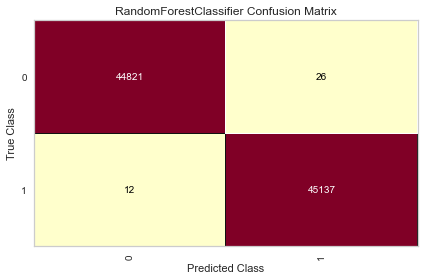

In [19]:
random_forest_visualizer = ConfusionMatrix(RandomForestClassifier(), classes=[0,1])                                        
random_forest_visualizer.fit (feature_matrix_train, target_train)
random_forest_visualizer.score(feature_matrix_test, target_test)
g=random_forest_visualizer.poof()

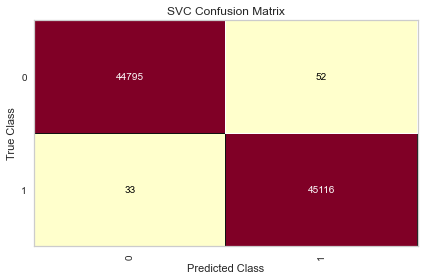

In [20]:
svm_visualizer = ConfusionMatrix(SVC(), classes=[0,1])                                        
svm_visualizer.fit (feature_matrix_train, target_train)
svm_visualizer.score(feature_matrix_test, target_test)
g=svm_visualizer.poof()

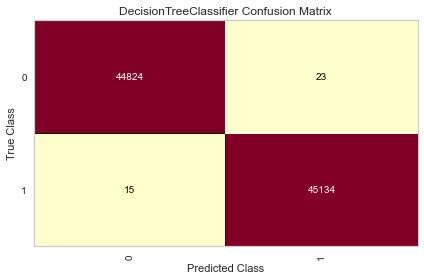

In [21]:
dt_visualizer = ConfusionMatrix(DecisionTreeClassifier(), classes=[0,1])                                          
dt_visualizer.fit (feature_matrix_train, target_train)
dt_visualizer.score(feature_matrix_test, target_test)
g=dt_visualizer.poof()

In [22]:
print(accuracy_score(target_test, rf_predictions_test))
print('Confusion Matrix\n', classification_report(target_test, rf_predictions_test))

0.9995666474065514
Confusion Matrix
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     44847
           1       1.00      1.00      1.00     45149

    accuracy                           1.00     89996
   macro avg       1.00      1.00      1.00     89996
weighted avg       1.00      1.00      1.00     89996



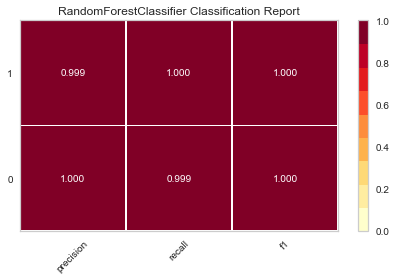

In [23]:
rf_clf_visualizer = ClassificationReport(RandomForestClassifier(), classes=[0,1])                                         
rf_clf_visualizer.fit (feature_matrix_train, target_train)
rf_clf_visualizer.score(feature_matrix_test, target_test)
g=rf_clf_visualizer.poof()

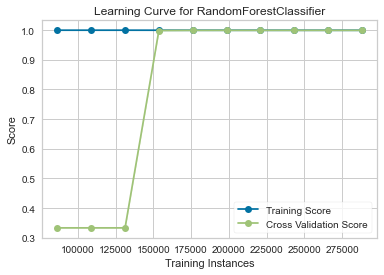

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [33]:
from yellowbrick.model_selection import LearningCurve
# Load a classification dataset
X = feature_matrix
y = target
# Create the learning curve visualizer
#cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
model = RandomForestClassifier()
visualizer = LearningCurve(
    model, cv=5, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

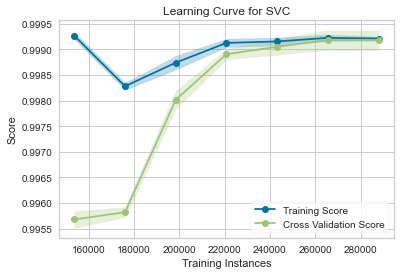

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [34]:
from yellowbrick.model_selection import LearningCurve
# Load a classification dataset
X = feature_matrix
y = target
# Create the learning curve visualizer
#cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
model = SVC()
visualizer = LearningCurve(
    model, cv=5, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

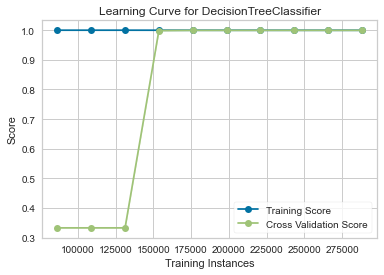

<AxesSubplot:title={'center':'Learning Curve for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [35]:
from yellowbrick.model_selection import LearningCurve
# Load a classification dataset
X = feature_matrix
y = target
# Create the learning curve visualizer
#cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
model = DecisionTreeClassifier()
visualizer = LearningCurve(
    model, cv=5, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [28]:
explainer = lime.lime_tabular.LimeTabularExplainer(feature_matrix_train, 
                                                  feature_names=feature_names,
                                                  class_names= ['Benign', 'Malicious'],
                                                  discretize_continuous=False)

exp= explainer.explain_instance(feature_matrix_test.iloc[17],
                               random_forest_clf.predict_proba,
                               num_features=5,
                               )

exp.show_in_notebook(show_table=True, show_all=False)
